# Bar data

In [1]:
from ib_insync import *
util.startLoop()

ib = IB()
ib.connect('127.0.0.1', 1301, clientId=14)

<IB connected to 127.0.0.1:1301 clientId=14>

## Historical data
To get the earliest date of available bar data the "head timestamp" can be requested:

In [2]:
contract = Stock('TSLA', 'SMART', 'USD')
ib.reqHeadTimeStamp(contract, whatToShow='TRADES', useRTH=True)

datetime.datetime(2010, 6, 29, 8, 0)

To request hourly data of the last 60 trading days:

In [3]:
%%time
bars = ib.reqHistoricalData(
            contract,
            endDateTime='',
            durationStr='60 D',
            barSizeSetting='1 hour',
            whatToShow='TRADES',
            useRTH=True,
            formatDate=1)

Wall time: 2.49 s


In [4]:
bars[0]

BarData(date=datetime.datetime(2020, 10, 1, 21, 30), open=440.76, high=441.8, low=436.23, close=437.1, volume=53954, average=438.703, barCount=23395)

Convert the list of bars to a dataframe and printe the first and last rows

In [5]:
df = util.df(bars)

display(df.head())
display(df.tail())

,date,open,high,low,close,volume,average,barCount
0,2020-10-01 21:30:00,440.76,441.80,436.23,437.10,53954,438.703,23395
1,2020-10-01 22:00:00,437.00,438.70,434.42,436.81,49089,436.557,22678
2,2020-10-01 23:00:00,436.80,440.52,435.43,438.88,45157,438.766,21441
3,2020-10-02 00:00:00,438.89,445.00,437.73,443.79,45644,441.626,21690
4,2020-10-02 01:00:00,443.80,448.00,443.68,445.57,53820,446.348,24848


,date,open,high,low,close,volume,average,barCount
409,2020-12-24 04:00:00,645.36,649.12,643.80,645.98,25999,646.788,13341
410,2020-12-24 22:30:00,642.99,652.22,641.00,649.71,26732,647.026,11621
411,2020-12-24 23:00:00,649.59,665.24,649.50,660.67,57187,659.266,26998
412,2020-12-25 00:00:00,660.69,666.01,657.64,665.80,30735,663.205,15181
413,2020-12-25 01:00:00,665.79,666.09,659.00,661.66,33333,661.804,15444


Instruct the notebook to draw plot graphics inline:

In [6]:
%matplotlib inline

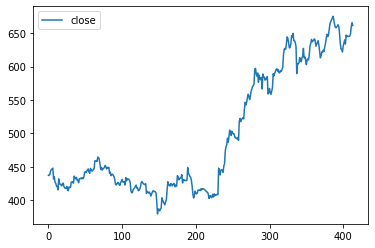

In [7]:
df.plot(y='close');

There is also a utility function to plot bars as a candlestick plot. It can accept either a DataFrame or a list of bars. Here it will print the last 100 bars:

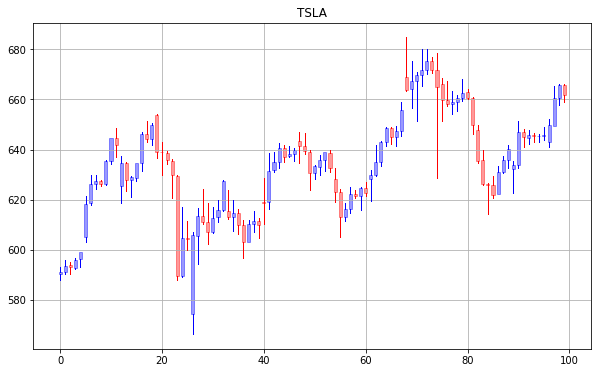

In [8]:
util.barplot(bars[-100:], title=contract.symbol);

## Historical data with realtime updates
A new feature of the API is to get live updates for historical bars. This is done by setting `endDateTime` to an empty string and the `keepUpToDate` parameter to `True`.

Let us get some bars with a *keepUpToDate* subscription:

In [9]:
contract = Forex('EURUSD')

bars = ib.reqHistoricalData(
            contract,
            endDateTime='',
            durationStr= '900 S',
            barSizeSetting='10 secs',
            whatToShow='MIDPOINT',
            useRTH=True,
            formatDate=1,
            keepUpToDate=True)

Replot for every change of the last bar:

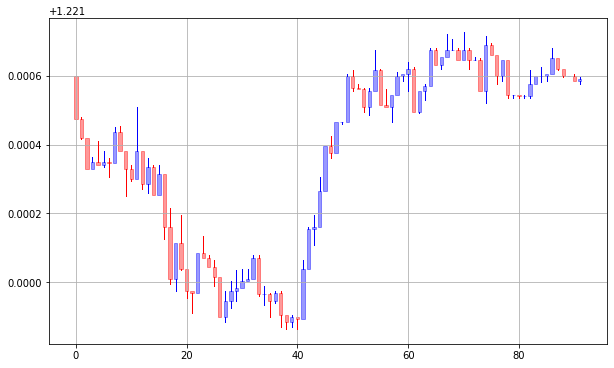

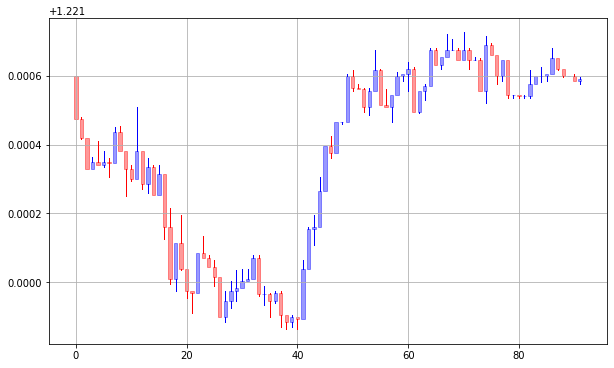

In [10]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

def onBarUpdate(bars, hasNewBar):
    plt.close()
    plot = util.barplot(bars)
    clear_output(wait=True)
    display(plot)
    
bars.updateEvent += onBarUpdate

ib.sleep(10)
ib.cancelHistoricalData(bars)

## Realtime bars
With `reqRealTimeBars` a subscription is started that sends a new bar every 5 seconds.

First we will set up an event handler for bar updates:

In [11]:
def onBarUpdate(bars, hasNewBar):
    print(bars[-1])

Then do the real request and connect the event handler

In [12]:
bars = ib.reqRealTimeBars(contract, 5, 'MIDPOINT', False)
bars.updateEvent += onBarUpdate

Let it run for half a minute and cancel the realtime bars

In [13]:
ib.sleep(30)
ib.cancelRealTimeBars(bars)

Error 162, reqId 5: Historical Market Data Service error message:API historical data query cancelled: 5


RealTimeBar(time=datetime.datetime(2020, 12, 28, 14, 13, 20, tzinfo=datetime.timezone.utc), endTime=-1, open_=1.221585, high=1.22159, low=1.221575, close=1.22158, volume=-1, wap=-1.0, count=-1)
RealTimeBar(time=datetime.datetime(2020, 12, 28, 14, 13, 25, tzinfo=datetime.timezone.utc), endTime=-1, open_=1.22158, high=1.22166, low=1.22158, close=1.22166, volume=-1, wap=-1.0, count=-1)
RealTimeBar(time=datetime.datetime(2020, 12, 28, 14, 13, 30, tzinfo=datetime.timezone.utc), endTime=-1, open_=1.22166, high=1.221725, low=1.22166, close=1.221725, volume=-1, wap=-1.0, count=-1)
RealTimeBar(time=datetime.datetime(2020, 12, 28, 14, 13, 35, tzinfo=datetime.timezone.utc), endTime=-1, open_=1.221725, high=1.22177, low=1.221725, close=1.22176, volume=-1, wap=-1.0, count=-1)
RealTimeBar(time=datetime.datetime(2020, 12, 28, 14, 13, 40, tzinfo=datetime.timezone.utc), endTime=-1, open_=1.22176, high=1.22182, low=1.221745, close=1.22179, volume=-1, wap=-1.0, count=-1)
RealTimeBar(time=datetime.datetim

The advantage of `reqRealTimeBars` is that it is more robust when connection t the IB server farms is interrupted. After the connection is restored, the bars missed during the outage will be backfilled and the live bars will resume.

reqHistoricalData + keepUpToDate will, at the moment of writing, leave the whole API inoperable after a network interruption.

In [14]:
ib.disconnect()